# Generative Adversarial Networks (GANs) - Vanilla GAN Tutorial


## import librarys
GAN 모델 구현에 필요한 library들을 import 합니다.
tensorflow, matplitlib(시각화), numpy(행렬), os(다양한 운영체제 관련 인터페이스 제공)

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
import os

## Discriminator
fake 이미지와 real 이미지를 판별하는 discriminator를 정의합니다.


- Architecture
    - Fully connected layer 784 to 256
    - relu activation function
    - Fully connected layer 256 to 1

In [2]:
def discriminator(x, reuse= True):
    with tf.variable_scope("discriminator", reuse= reuse):
        net = tf.layers.dense(inputs = x, units =256,name = "d_w1")
        net = tf.nn.relu(net)
        net = tf.layers.dense(inputs = net, units =1,name = "d_w2")
    return net

## Generator
random vector를 받아 fake image를 만드는 generator를 정의합니다
- Architecture
    - Fully connected layer 100 to 256
    - relu activation function
    - Fuuly connected layer 256 to 784
    - sigmoid activation function

In [3]:
def generator(z, reuse = False):
    with tf.variable_scope("generator", reuse = reuse):
        net = tf.layers.dense(inputs = z, units = 256,name = "g_w1")
        net = tf.nn.relu(net)
        net = tf.layers.dense(inputs = net, units = 784,name = "g_w2")
        net = tf.nn.sigmoid(net)
    return net

## Display function - Sample Image 

In [4]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]),cmap = plt.cm.gray)
    return

## 데이터 및 hyper parameter 준비
* example data set으로 tensorflow에 저장되어있는 mnist 데이터를 이용한다.


* learning_rate 학습 속도를 0.0002, batch_size = 100, training_epoch를 100으로 설정한다.


* data를 feed했을 때 받을 placeholder를 정의한다.


* x는 mnist데이터를 받는 placeholder, z는 random 으로 생성한 난수를 받는 placeholder를 정의한다.

In [5]:
mnist = input_data.read_data_sets("./data/mnist", one_hot= True)

batch_size = 100
training_epoch = 100
learning_rate = 0.0002
z_size = 128

x = tf.placeholder(tf.float32, shape = [None, 784])
z = tf.placeholder(tf.float32, shape = [None, z_size])

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/mnist\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/mnist\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./data/mnist\t10k-images-idx3-ubyte.gz
Extracting ./data/mnist\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## define logit
만들어 놓은 generator와 discriminator를 통해서 이미지 생성 및 discriminator에 진짜와 가짜를 넣어 판단한 logit을 만든다.

In [6]:
g = generator(z,reuse = False)
d_real_logit = discriminator(x, reuse = False)
d_fake_logit = discriminator(g)

sample_g = generator(z,reuse =True) # sample 이미지를 생성하기 위한 generator

## define Loss function
* d_real_loss는 d_real_logit(discriminator가 real image를 판단한 결과)를 1로 판단(진짜 이미지로 판단)하게 할수 있도록 loss를 형성
* d_fake_loss는 d_fake_logit(discriminator가 generator가 만든 image를 판단한 결과)를 0으로 판단(가짜 이미지로 판단)하게 할수 있도록 loss를 형성
* g_loss는 d_fake_loss(discriminator가 generator가 만든 image를 판단한 결과)를 1로(진짜 이미지로 판단)하게 할수 있도록 Loss를 형성


In [7]:
d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_real_logit, labels = tf.ones_like(d_real_logit)))
d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_fake_logit, labels = tf.zeros_like(d_fake_logit)))
d_loss = d_real_loss + d_fake_loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_fake_logit, labels = tf.ones_like(d_fake_logit)))

## define Optimizer
* tf.trainable_variables() 함수를 통해서 정의된 모든 변수의 list를 t_vars라는 변수에 저장한다.

* d_vars = [var for var in t_vars if 'd_' in var.name] Discriminator에 사용된 변수를 d_vars에 저장한다.

* g_vars = [var for var in t_vars if 'g_' in var.name] Generator에 사용된 변수를 g_vars에 저장한다.

* AdamOptimizer를 통해서 Discriminator와 Generator를 학습시킨다. 

In [8]:
t_vars = tf.trainable_variables()
d_vars = [var for var in t_vars if 'd_' in var.name]
g_vars = [var for var in t_vars if 'g_' in var.name]

d_trainer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(d_loss, var_list = d_vars)
g_trainer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(g_loss, var_list = g_vars)


## Train

Epoch : 0 , Batch : 549 , D_loss : 0.1846921741962433 , G_loss 3.136387586593628 


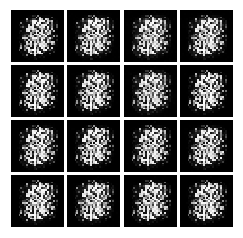

Epoch : 5 , Batch : 549 , D_loss : 0.018717270344495773 , G_loss 6.774332046508789 
Epoch : 10 , Batch : 549 , D_loss : 0.05891084671020508 , G_loss 4.965429306030273 


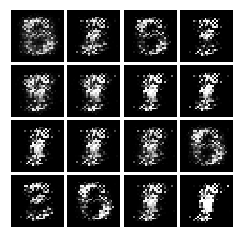

Epoch : 15 , Batch : 549 , D_loss : 0.19186408817768097 , G_loss 4.198168754577637 
Epoch : 20 , Batch : 549 , D_loss : 0.13353687524795532 , G_loss 5.0409393310546875 


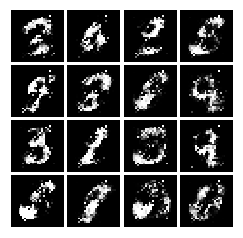

Epoch : 25 , Batch : 549 , D_loss : 0.19641897082328796 , G_loss 4.429855823516846 
Epoch : 30 , Batch : 549 , D_loss : 0.19337400794029236 , G_loss 4.4756269454956055 


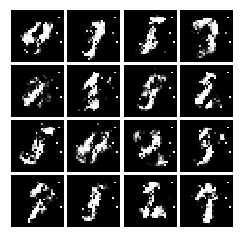

Epoch : 35 , Batch : 549 , D_loss : 0.10852040350437164 , G_loss 5.045803070068359 
Epoch : 40 , Batch : 549 , D_loss : 0.17737743258476257 , G_loss 5.255250930786133 


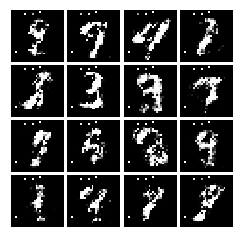

Epoch : 45 , Batch : 549 , D_loss : 0.3255975842475891 , G_loss 4.426389694213867 
Epoch : 50 , Batch : 549 , D_loss : 0.3820039927959442 , G_loss 4.633098602294922 


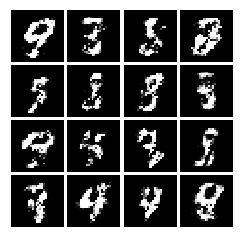

Epoch : 55 , Batch : 549 , D_loss : 0.3444139361381531 , G_loss 3.655682325363159 
Epoch : 60 , Batch : 549 , D_loss : 0.2369222193956375 , G_loss 4.268476486206055 


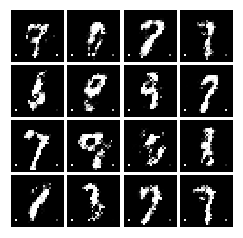

Epoch : 65 , Batch : 549 , D_loss : 0.34057724475860596 , G_loss 3.9809792041778564 
Epoch : 70 , Batch : 549 , D_loss : 0.07148818671703339 , G_loss 5.0011115074157715 


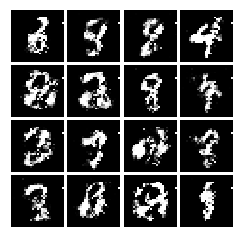

Epoch : 75 , Batch : 549 , D_loss : 0.26646605134010315 , G_loss 3.8496642112731934 
Epoch : 80 , Batch : 549 , D_loss : 0.457356333732605 , G_loss 4.275001049041748 


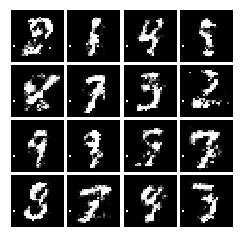

Epoch : 85 , Batch : 549 , D_loss : 0.16904594004154205 , G_loss 4.014496803283691 
Epoch : 90 , Batch : 549 , D_loss : 0.23439288139343262 , G_loss 3.25666880607605 


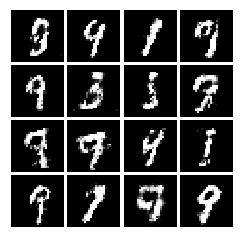

Epoch : 95 , Batch : 549 , D_loss : 0.3739171624183655 , G_loss 3.1193935871124268 


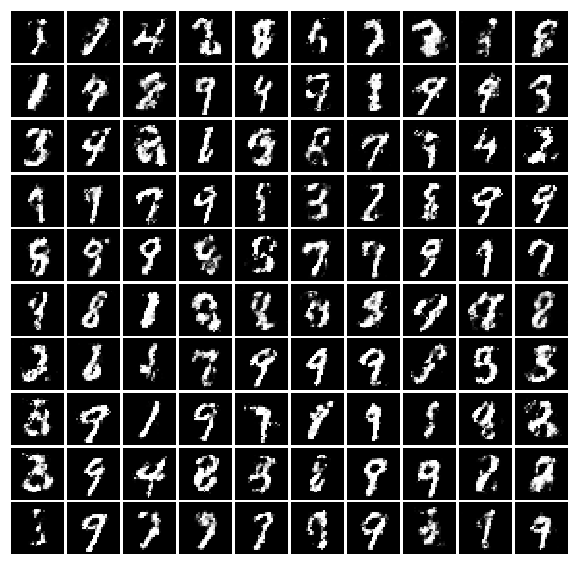

In [10]:
with tf.Session() as sess:
        init = tf.global_variables_initializer() # 변수 초기화
        sess.run(init)
        
        if not os.path.exists('samples'): # samples라는 폴더가 없다면 폴더를 형성한다.
            os.makedirs('samples')
        
        for epoch in range(training_epoch):
            total_batch =  int(mnist.train.num_examples / batch_size) 
            
            for batch in range(total_batch):
                random_z = np.random.uniform(-1,1,size = [batch_size,z_size])
                sample_z = np.random.uniform(-1,1,size = [batch_size,z_size])
                sample_image = sess.run(sample_g, feed_dict = {z:sample_z})
                batch_xs, _ = mnist.train.next_batch(batch_size)
                _, d_loss_val = sess.run([d_trainer, d_loss], feed_dict = {x:batch_xs, z: random_z})
                _, g_loss_val = sess.run([g_trainer, g_loss], feed_dict = {z:random_z})
                                
            if epoch % 5 == 0:
                print("Epoch : {} , Batch : {} , D_loss : {} , G_loss {} ".format(epoch, batch, d_loss_val,g_loss_val))
            if epoch % 10 == 0 : 
                show_images(sample_image[:16])
                plt.savefig('samples/{}.png'.format(str(epoch).zfill(3)),bbox_inches = 'tight')
                plt.show()
        show_images(sample_image)
        plt.savefig('samples/{}.png'.format(str(epoch).zfill(3)),bbox_inches = 'tight')
        plt.show()
            